In [1]:
import os
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import eigsh

import netket.operator as nkop
from netket.graph import Hypercube
from netket.hilbert import Spin
from netket.operator import Ising

import matplotlib.pyplot as plt

<Axes: >

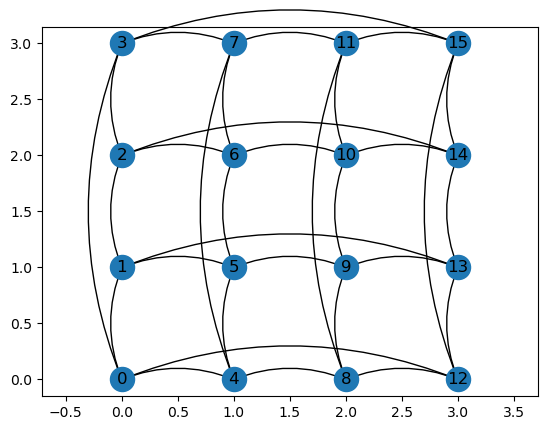

In [2]:
# set system parameters
SIDE_LENGTH = 4
PERIODIC_BOUNDARIES = True
J_COUPLING = -1.0

#### DRAW GRAPH ####

graph = Hypercube(length=SIDE_LENGTH, n_dim=2, pbc=PERIODIC_BOUNDARIES)
graph.draw()

In [3]:
hilbert = Spin(s=0.5, N=graph.n_nodes)

def tfim_hamiltonian(hilbert, graph, h, J):
    return Ising(hilbert, graph, h=h, J=J)

def get_ground_state(hamiltonian):
    sp_mat = hamiltonian.to_sparse()
    vals, vecs = eigsh(sp_mat, k=1, which="SA")
    psi = vecs[:, 0]

    # rotate so the largest amplitude is Real and Positive
    first_idx = np.argmax(np.abs(psi))
    psi = psi * np.exp(-1j * np.angle(psi[first_idx]))
    return vals[0], psi


#### CHECK HAMILTONIAN AND GROUND STATE ####

ham_test = tfim_hamiltonian(hilbert, graph, h=1.0, J=J_COUPLING)
E0, psi = get_ground_state(ham_test)

# check physical regime via two-point correlator
u, v = list(graph.edges())[0]
op_zz = nkop.spin.sigmaz(hilbert, u) * nkop.spin.sigmaz(hilbert, v)
zz_corr = (psi.conj().T @ (op_zz.to_sparse() @ psi)).real

phys_regime = "Ferromagnetic (FM)" if zz_corr > 0 else "Antiferromagnetic (AFM)"

# check matrix elements for stoquasticity
sp_mat = ham_test.to_sparse()
off_diag = sp_mat - scipy.sparse.diags(sp_mat.diagonal())
max_off_diag = np.max(off_diag.data.real) if off_diag.nnz > 0 else 0.0
is_stoquastic_ham = max_off_diag <= 1e-12

# check wavefunction amplitudes
max_imag = np.max(np.abs(psi.imag))
min_real = np.min(psi.real)
is_positive_wf = (max_imag < 1e-10) and (min_real > -1e-10)


title = "HAMILTONIAN ANALYSIS"
print(f"==== {title} {'='*(60 - 6 - len(title))}")
print(f"Parameters:               h=1.0, J={J_COUPLING}")
print(f"Ground State Energy:      {E0:.8f}")
print(f"Hamiltonian Stoquastic?   {str(is_stoquastic_ham).upper():<5} (Max Off-Diag H: {max_off_diag:.1e})")
print("="*60)


title = "STATE VECTOR INSPECTION"
print(f"\n==== {title} {'='*(60 - 6 - len(title))}")

sorted_indices = np.argsort(np.abs(psi))[::-1]
print(f"First 5 Dominant Amplitudes:")
print(f"{'Index':<6} | {'Real Part':<11} | {'Imag Part':<11} | {'Sign'}")
print("-"*60)
for i in sorted_indices[:5]:
    val = psi[i]
    if val.real > 1e-6: sign = "+"
    elif val.real < -1e-6: sign = "-"
    else: sign = "0"
    print(f"{i:<6} | {val.real:+.6f}   | {val.imag:+.6f}   | {sign}")

print("-"*60)
print(f"Two-Point Correlator Czz: {zz_corr:+.4f} -> {phys_regime}")
print(f"Wavefunction Real?        {str(max_imag < 1e-10).upper():<5} (Max Imag Psi:   {max_imag:.1e})")
print(f"Wavefunction Positive?    {str(is_positive_wf).upper():<5} (Min Real Psi:   {min_real:.1e})")
print("="*60)


title = "RBM TRAINING VIABILITY"
print(f"\n==== {title} {'='*(60 - 6 - len(title))}")

if is_positive_wf:
    print("SUCCESS: The state is Real and Positive.")
    print("This is valid for a standard amplitude-only RBM.")
elif not is_positive_wf and zz_corr < 0:
    print("FAILURE: System is Antiferromagnetic and Frustrated.")
    print("The ground state has a sign structure. You cannot use a standard RBM.")
else:
    print("WARNING: State is not strictly positive. Check h and J parameters.")
print("="*60)

==== HAMILTONIAN ANALYSIS ==================================
Parameters:               h=1.0, J=-1.0
Ground State Energy:      -34.01059755
Hamiltonian Stoquastic?   TRUE  (Max Off-Diag H: -1.0e+00)

==== STATE VECTOR INSPECTION ===============================
First 5 Dominant Amplitudes:
Index  | Real Part   | Imag Part   | Sign
------------------------------------------------------------
65535  | +0.621840   | +0.000000   | +
0      | +0.621840   | +0.000000   | +
65023  | +0.078142   | +0.000000   | +
65531  | +0.078142   | +0.000000   | +
65527  | +0.078142   | +0.000000   | +
------------------------------------------------------------
Two-Point Correlator Czz: +0.9365 -> Ferromagnetic (FM)
Wavefunction Real?        TRUE  (Max Imag Psi:   7.6e-17)
Wavefunction Positive?    TRUE  (Min Real Psi:   8.4e-08)

==== RBM TRAINING VIABILITY ================================
SUCCESS: The state is Real and Positive.
This is valid for a standard amplitude-only RBM.


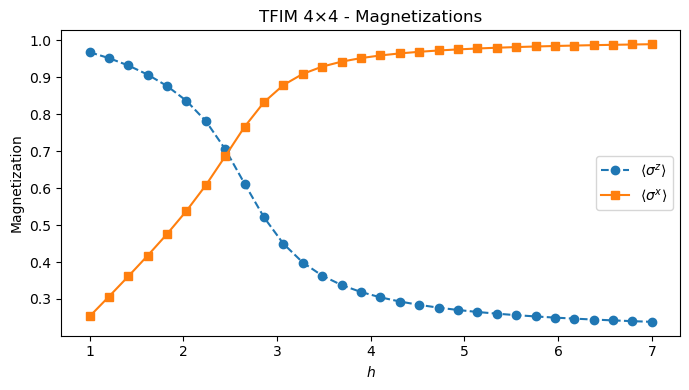

In [4]:
def get_magnetizations(state: np.ndarray, hilbert, graph):
    psi = np.asarray(state, dtype=np.complex128)
    N = graph.n_nodes

    Mz_op = nkop.LocalOperator(hilbert, dtype=np.complex128)
    Mx_op = nkop.LocalOperator(hilbert, dtype=np.complex128)

    for i in range(N):
        Mz_op += nkop.spin.sigmaz(hilbert, i)
        Mx_op += nkop.spin.sigmax(hilbert, i)

    Mz_mat = Mz_op.to_sparse() / N
    Mx_mat = Mx_op.to_sparse() / N

    # Mz is diagonal in this basis, we can get |Mz| by just taking the absolute value of the diagonal elements.
    mz_diag = Mz_mat.diagonal()
    probs = np.abs(psi)**2
    mz_abs = np.dot(probs, np.abs(mz_diag))

    mx = np.vdot(psi, Mx_mat @ psi).real

    return mz_abs, mx


#### SWEEP OVER TRANSVERSE FIELD ####

h_min, h_max = 1.0, 7.0
num_points = 30
h_vals = np.linspace(h_min, h_max, num_points)

mag_z_vals, mag_x_vals = [], []
for h in h_vals:
    ham = tfim_hamiltonian(hilbert, graph, h=float(h), J=J_COUPLING)
    _, psi = get_ground_state(ham)

    mz, mx = get_magnetizations(psi, hilbert, graph)

    mag_z_vals.append(mz)
    mag_x_vals.append(mx)

mag_z_vals = np.array(mag_z_vals)
mag_x_vals = np.array(mag_x_vals)


#### PLOTTING ####

plt.figure(figsize=(7, 4))
plt.plot(h_vals, mag_z_vals, "o--", label=r"$\langle \sigma^z \rangle$")
plt.plot(h_vals, mag_x_vals, "s-",  label=r"$\langle \sigma^x \rangle$")

plt.xlabel(r"$h$")
plt.ylabel("Magnetization")
plt.title(f"TFIM {SIDE_LENGTH}×{SIDE_LENGTH} - Magnetizations")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
data = np.column_stack([h_vals, mag_z_vals, mag_x_vals])
header = "h,mag_z,mag_x"

file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv"

np.savetxt(file_name, data, delimiter=",", header=header, comments="", fmt="%.6e")
print(f"Saved reference magnetizations to: {os.path.abspath(file_name)}")

Saved reference magnetizations to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/parametric_qst_single/tfim_4x4/tfim_4x4_magnet_ref.csv
